In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost onnxmltools skl2onnx jupyter

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('../data/transactions.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


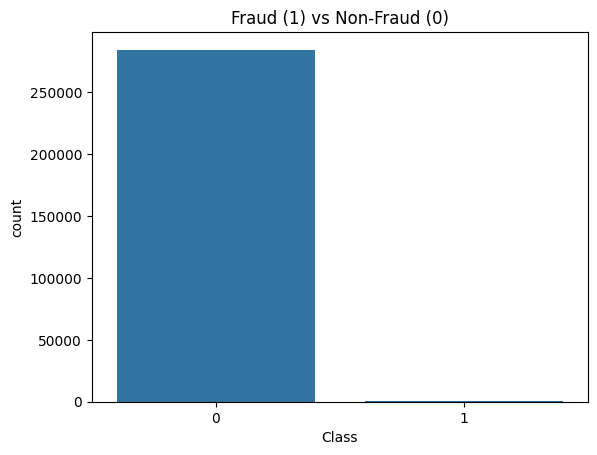

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [4]:
sns.countplot(data=df, x='Class')
plt.title('Fraud (1) vs Non-Fraud (0)')
plt.show()

print(df['Class'].value_counts(normalize=True))

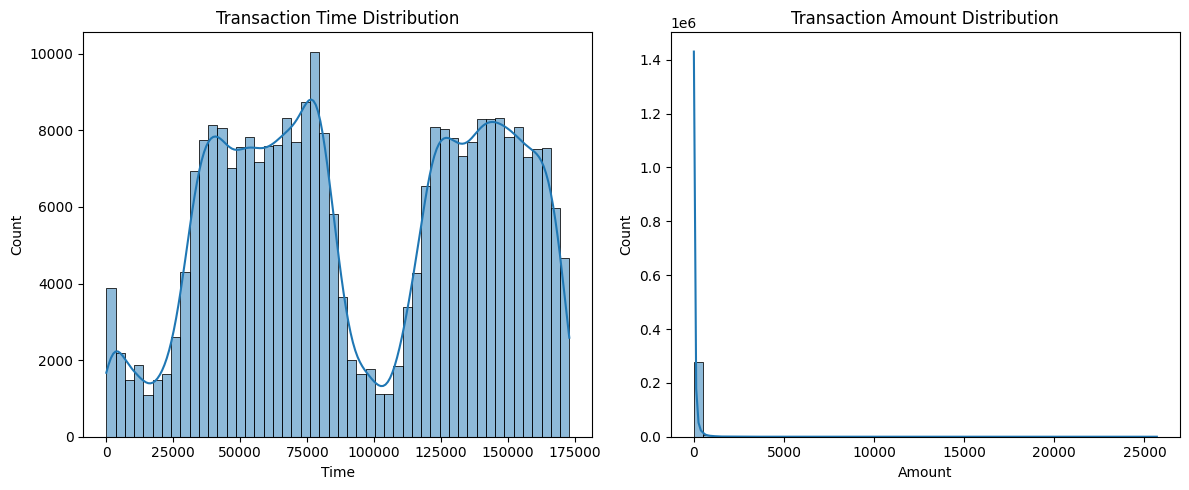

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Time'], bins=50, ax=ax[0], kde=True)
sns.histplot(df['Amount'], bins=50, ax=ax[1], kde=True)
ax[0].set_title('Transaction Time Distribution')
ax[1].set_title('Transaction Amount Distribution')
plt.tight_layout()
plt.show()

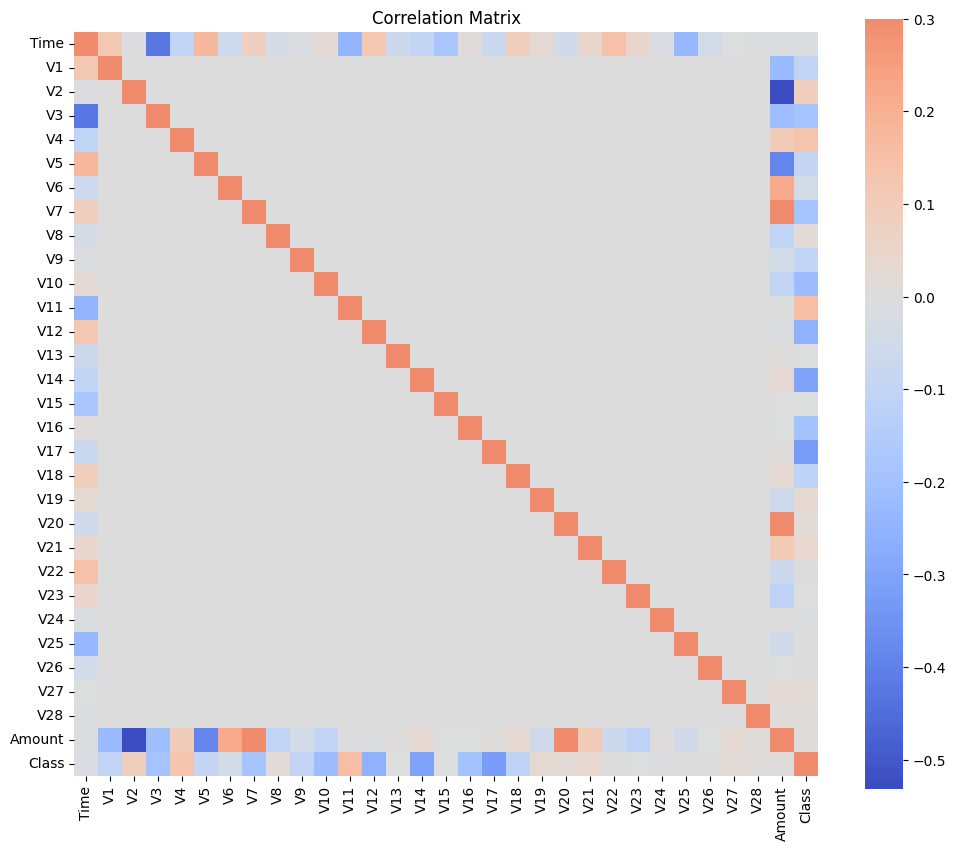

In [6]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmax=0.3, center=0, square=True)
plt.title("Correlation Matrix")
plt.show()

In [7]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [8]:
df.to_csv('../data/cleaned_transactions.csv', index=False)
print("Data preprocessing complete. Cleaned data saved to 'cleaned_transactions.csv'.")

Data preprocessing complete. Cleaned data saved to 'cleaned_transactions.csv'.


# Let's Start Modelling

## Importing

In [9]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

## Prepare Data

In [10]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Convert to NumPy (to avoid feature name issues)
X_np = X_train.values.astype(np.float32)
y_np = y_train.values


## Train XGBoost with Class Weight

In [11]:
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(
    scale_pos_weight=fraud_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_np, y_np)

c:\Users\yasas\anaconda3\envs\fraud-env\lib\site-packages\xgboost\training.py:183: UserWarning: [22:11:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Evaluate the Model

In [12]:
y_pred = model.predict(X_test.values.astype(np.float32))
y_proba = model.predict_proba(X_test.values.astype(np.float32))[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.79      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85279    16]
 [   31   117]]
ROC AUC Score: 0.9705331100489082


## Export to ONNX

In [13]:
initial_type = [('float_input', FloatTensorType([None, X_np.shape[1]]))]

onnx_model = convert_xgboost(model, initial_types=initial_type)

with open("../model/fraud_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ Model exported successfully to model/fraud_model.onnx")

✅ Model exported successfully to model/fraud_model.onnx


In [14]:
import onnx
onnx_model = onnx.load("../model/fraud_model.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid ✅")

ONNX model is valid ✅


In [15]:
import onnxruntime as rt
import numpy as np

session = rt.InferenceSession("../model/fraud_model.onnx")
sample = X_test.iloc[0:1].values.astype(np.float32)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

onnx_pred = session.run([output_name], {input_name: sample})[0]
print("ONNX output:", onnx_pred)

ONNX output: [0]


## Trying to return probablities

In [16]:
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType

# Define the input shape
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

# Export the model to ONNX with class probability output enabled
onnx_model = convert_xgboost(
    model,
    initial_types=initial_type
)

# Save the model
with open("../model/fraud_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ XGBoost model exported with class probabilities (predict_proba).")

✅ XGBoost model exported with class probabilities (predict_proba).


In [17]:
import onnxruntime as rt
import numpy as np

session = rt.InferenceSession("../model/fraud_model.onnx", providers=["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

sample = X_test.iloc[0:1].values.astype(np.float32)

onnx_output = session.run([output_name], {input_name: sample})[0]
print("🔍 ONNX predicted probabilities:", onnx_output)

🔍 ONNX predicted probabilities: [0]


## Trying with raw probabilities

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import numpy as np

# ✅ Train a compatible model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# 🧠 Set the ONNX input type
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

# ✅ Export ONNX with class probability output
onnx_model = convert_sklearn(
    model,
    initial_types=initial_type,
    options={id(model): {'zipmap': False}}  # Disable zipmap to get NumPy array directly
)

# 💾 Save the model
with open("../model/fraud_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ Exported GradientBoostingClassifier to ONNX with probability support.")

✅ Exported GradientBoostingClassifier to ONNX with probability support.


c:\Users\yasas\anaconda3\envs\fraud-env\lib\site-packages\skl2onnx\operator_converters\gradient_boosting.py:109: RuntimeWarning: overflow encountered in cast
  attrs[k] = np.array(attrs[k], dtype=dtype)


In [20]:
# Load the ONNX model
session = rt.InferenceSession("../model/fraud_model.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Predict on a sample
sample = X_test.iloc[0:1].values.astype(np.float32)
onnx_output = session.run([output_name], {input_name: sample})[0]

print("🔍 ONNX predict_proba output:", onnx_output)

🔍 ONNX predict_proba output: [0]


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import numpy as np
import onnxruntime as rt

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [25]:
# Define input type
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]

# Export ONNX
onnx_model = convert_sklearn(
    model,
    initial_types=initial_type,
    options={id(model): {'zipmap': False}}  # ⬅️ this is key
)

# Save the model
with open("fraud_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

c:\Users\yasas\anaconda3\envs\fraud-env\lib\site-packages\skl2onnx\operator_converters\gradient_boosting.py:109: RuntimeWarning: overflow encountered in cast
  attrs[k] = np.array(attrs[k], dtype=dtype)


In [27]:
# Load ONNX model
session = rt.InferenceSession("fraud_model.onnx", providers=['CPUExecutionProvider'])

# Get input/output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Prepare input sample
sample = X_test.iloc[0:1].values.astype(np.float32)

# Run inference
output = session.run([output_name], {input_name: sample})[0]
print("ONNX output probabilities:", output)

ONNX output probabilities: [1]


## Final Try

In [29]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

# 1. Sample data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 2. Train model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# 3. Export to ONNX
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(model, initial_types=initial_type, options={id(model): {'zipmap': False}})
with open("fraud_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# 4. Inference
sess = rt.InferenceSession("fraud_model.onnx", providers=['CPUExecutionProvider'])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Print input/output names for verification
print("Input name:", input_name)
print("Output name:", output_name)

# 5. Predict
sample_input = X_test[:1].astype(np.float32)
onnx_output = sess.run([output_name], {input_name: sample_input})[0]
print("ONNX output probabilities:", onnx_output)

Input name: float_input
Output name: label
ONNX output probabilities: [0]


In [30]:
print(sess.get_outputs())

[<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000001C13BCAFFB0>, <onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x000001C13BCAEA70>]


In [34]:
# Print output names and shapes
for o in sess.get_outputs():
    print(f"Name: {o.name}, Type: {o.type}, Shape: {o.shape}")

Name: label, Type: tensor(int64), Shape: [None]
Name: probabilities, Type: tensor(float), Shape: [None, 2]


In [36]:
for output in sess.get_outputs():
    print("Name:", output.name)

Name: label
Name: probabilities


In [37]:
output_name = "probabilities"  # Replace this

sample_input = X_test[:1].astype(np.float32)
onnx_output = sess.run([output_name], {input_name: sample_input})[0]
print("✅ ONNX output probabilities:", onnx_output)


✅ ONNX output probabilities: [[0.97089    0.02911001]]
